# Project 3 - Analysis Workbook

### Objective
Determine whether it would be feasible to create an application that can estimate accurately estimate the <b>Nutriscore Grade</b> and <b>NOVA Score</b> of products based on minimal input from the user.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [2]:
#Open dataset
data = pd.read_csv('openfoodfacts_cleaned_20200228.csv', low_memory = False)

In [3]:
#Set Environment
pd.set_option('display.max_columns', 70)
pd.set_option('display.max_rows', 50)

In [4]:
data.describe()

,Unnamed: 0,created_t,last_modified_t,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g,nutrition-score-fr_100g
count,3.613220e+05,3.613220e+05,3.613220e+05,1.550870e+05,275216.000000,275216.000000,275216.000000,284972.000000,338442.000000,337772.000000,323569.000000,65359.000000,66290.000000,337719.000000,333282.000000,170461.000000,337401.000000,335238.000000,335216.000000,64838.000000,67736.000000,70659.000000,66226.000000,245352.000000
mean,5.176302e+05,1.503413e+09,1.542740e+09,7.164437e+16,2.052083,0.033919,0.104551,985.280613,976.329148,11.007667,3.999497,0.069985,0.025338,26.081440,11.085086,1.971160,6.818034,0.691946,0.276768,0.002265,0.029757,0.106462,0.006104,7.591517
std,3.180082e+05,4.545610e+07,3.562009e+07,2.821433e+19,2.565116,0.183493,0.382813,721.917893,718.957146,13.273105,5.110556,0.921553,0.564577,25.514935,13.857221,2.148808,6.430870,0.673713,0.269296,0.314145,0.942894,1.266422,0.228306,8.456187
min,1.200000e+01,1.328021e+09,1.333873e+09,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,2.442202e+05,1.489058e+09,1.521283e+09,3.000000e+01,0.000000,0.000000,0.000000,339.000000,335.000000,0.700000,0.120000,0.000000,0.000000,4.700000,1.000000,0.000000,1.500000,0.090000,0.036000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,4.894655e+05,1.504901e+09,1.556718e+09,7.500000e+01,1.000000,0.000000,0.000000,870.000000,849.000000,5.700000,1.790000,0.000000,0.000000,14.290000,4.440000,1.400000,5.300000,0.530000,0.212000,0.000000,0.000000,0.046000,0.000870,5.000000
75%,7.738192e+05,1.535455e+09,1.568396e+09,1.500000e+02,3.000000,0.000000,0.000000,1544.000000,1531.000000,18.000000,6.000000,0.000000,0.026000,49.000000,16.000000,3.100000,10.000000,1.168400,0.467360,0.000101,0.003800,0.118000,0.002060,14.000000
max,1.131128e+06,1.580429e+09,1.580432e+09,1.111111e+22,38.000000,3.000000,6.000000,3238.000000,3269.000000,100.000000,20.000000,85.700000,93.800000,100.000000,53.000000,9.000000,26.000000,14.140180,1.000000,73.000000,100.000000,100.000000,28.800000,36.000000


In [5]:
#Drop Unnamed column that serves no purpose
data.drop(columns=["Unnamed: 0"], inplace = True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361322 entries, 0 to 361321
Data columns (total 53 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     361322 non-null  object 
 1   url                                      361322 non-null  object 
 2   creator                                  361321 non-null  object 
 3   created_t                                361322 non-null  int64  
 4   created_datetime                         361322 non-null  object 
 5   last_modified_t                          361322 non-null  int64  
 6   last_modified_datetime                   361322 non-null  object 
 7   product_name                             359111 non-null  object 
 8   quantity                                 180856 non-null  object 
 9   packaging                                134016 non-null  object 
 10  brands                          

## Univaried Analysis

The Nutriscore Grade is calculated based on the following ingredients: <br>
-Bad Ingredients: Energy (KJ), Sugars, Salt, Saturated Fats <br>
-Good Ingredients: Proteins, Fibers, Vegetable/Fruit/Nut composition<br>

As such, we expect to see a high correlation with these variables <br>
source: https://www.health.belgium.be/fr/le-nutri-score

In [7]:
#Create a list of important variables, Veg/fruit/nut composition was a poorly filled out column and is therefore not available
key_vars = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g', 'proteins_100g']

#It will also be interesting to test out other variables where we expect no direct relationship
other_vars = ['energy-kcal_100g', 'carbohydrates_100g', 'calcium_100g', 'iron_100g', 'cholesterol_100g', 'fat_100g', 'additives_n']

### Quantitative

Let us first examine the distribution of the key variables

#### Histograms

In [8]:
#Function to do a univaried analysis on a single column and return statistical info about the column
def dist(column):
    fig, ax = plt.subplots(figsize = (12,6))
    sns.distplot(data[column].dropna(), kde = False, color = 'maroon')
    plt.ylabel('Number of Records', fontsize = 12)
    plt.xlabel(column,fontsize = 12)
    plt.title(f'Histogram: {column}', fontsize = 16)
    plt.show()
    skew = round(data[column].skew(skipna = True),2) #Skewness coefficient
    var = round(st.variation(data[column].dropna()),2) #Coefficient of Variation
    kurt = round(st.kurtosis(data[column].dropna()),2)
    print(
f'''Skewness Coefficient: {skew}
Coefficient of Variation: {var}
Kurtosis: {kurt}
''')

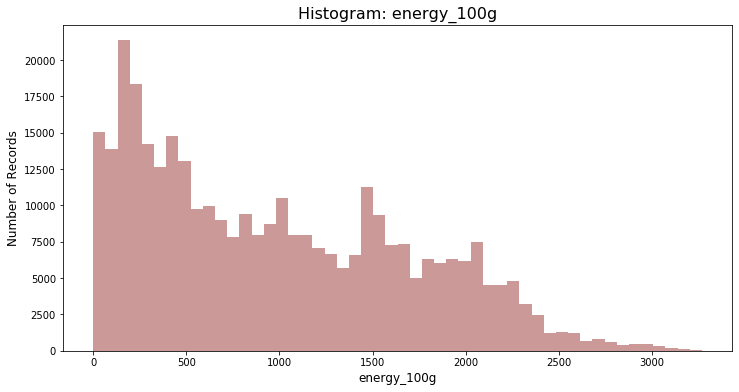

Skewness Coefficient: 0.52
Coefficient of Variation: 0.74
Kurtosis: -0.77



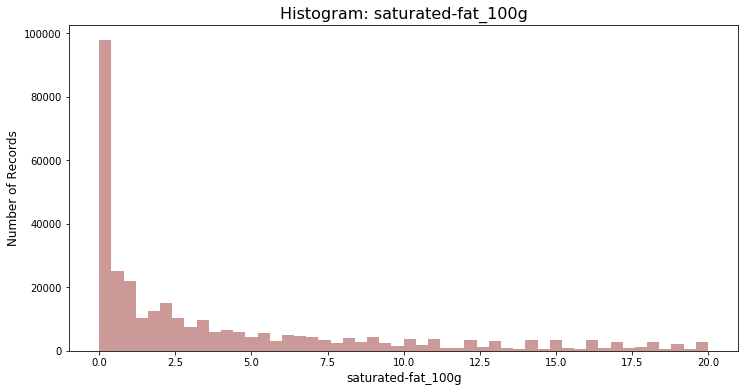

Skewness Coefficient: 1.46
Coefficient of Variation: 1.28
Kurtosis: 1.19



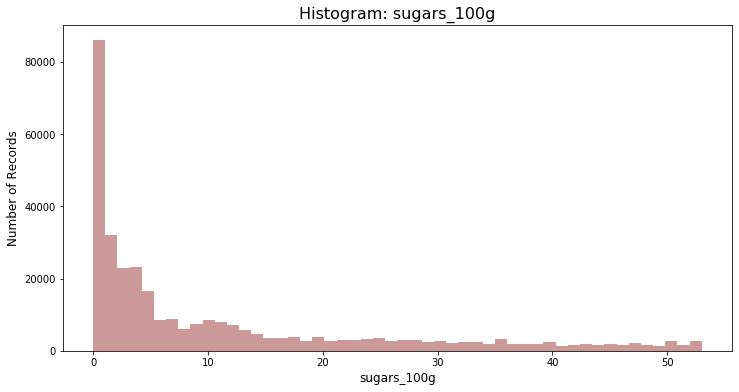

Skewness Coefficient: 1.43
Coefficient of Variation: 1.25
Kurtosis: 0.98



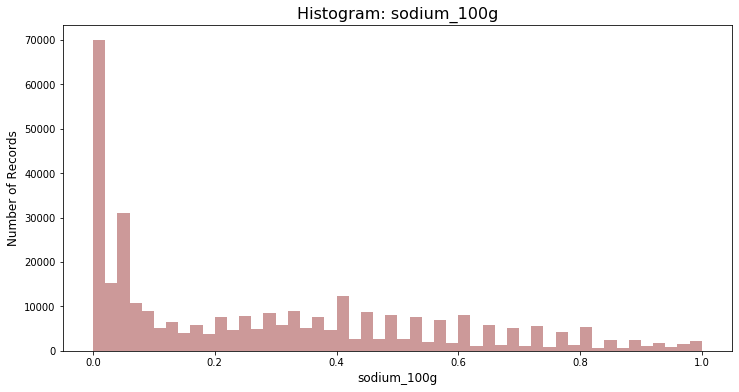

Skewness Coefficient: 0.76
Coefficient of Variation: 0.97
Kurtosis: -0.49



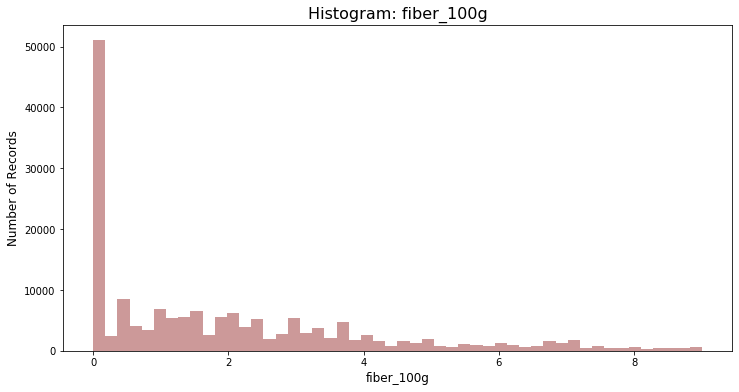

Skewness Coefficient: 1.2
Coefficient of Variation: 1.09
Kurtosis: 0.76



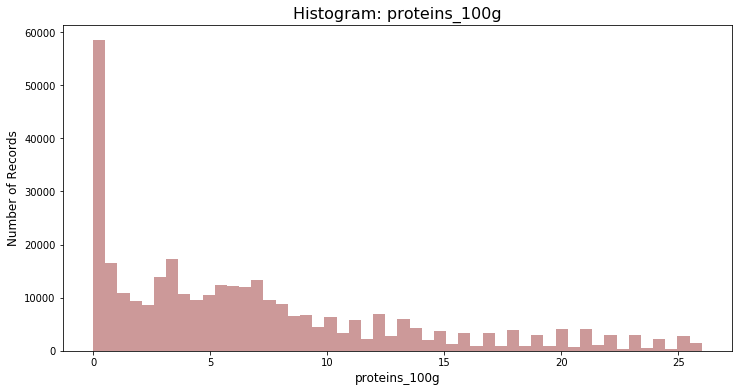

Skewness Coefficient: 1.08
Coefficient of Variation: 0.94
Kurtosis: 0.44



In [9]:
#Generate histograms for all key variables
for i in key_vars:
    plt.show()
    dist(i)

#### Boxplots

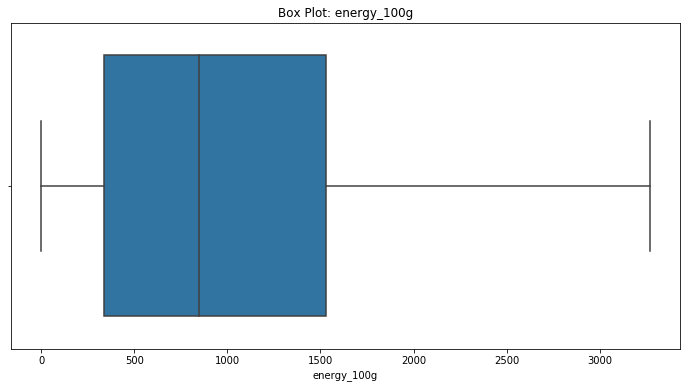

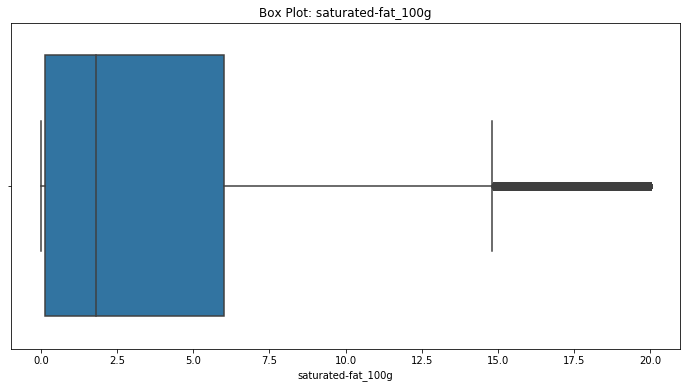

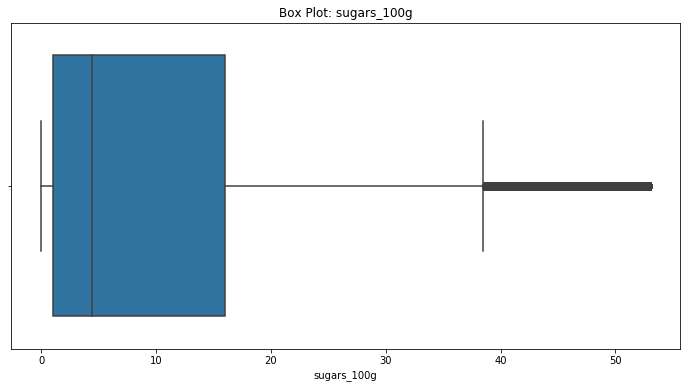

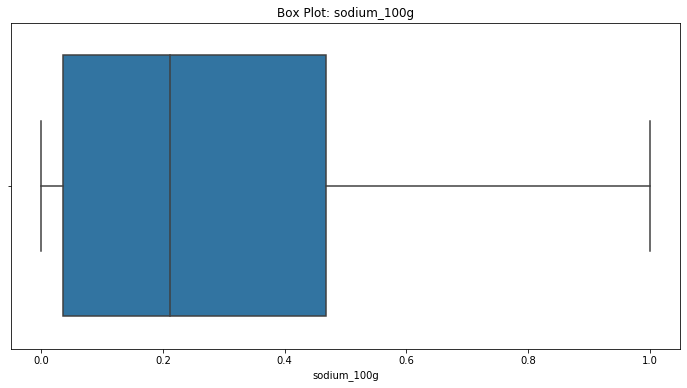

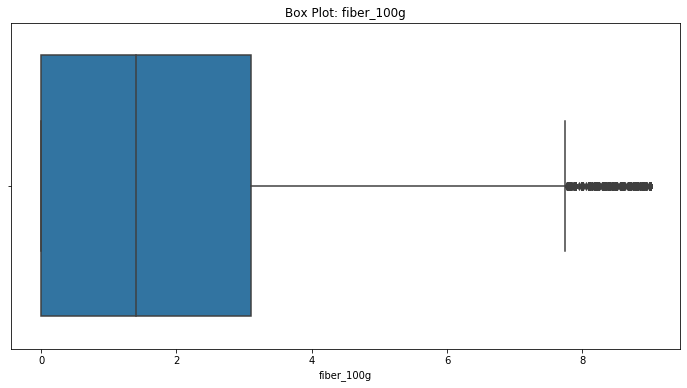

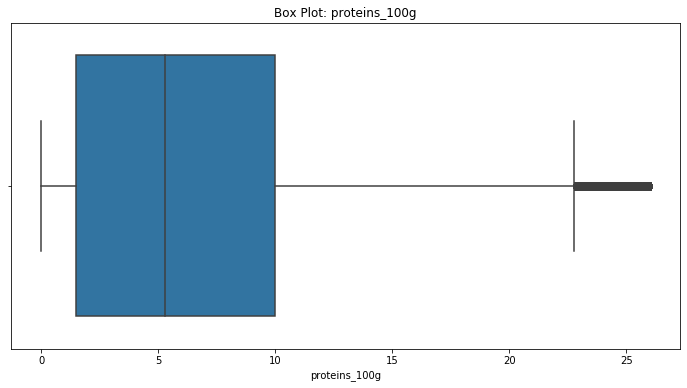

In [10]:
#Generate box plots for all key variables
for i in key_vars:
    fig, ax = plt.subplots(figsize = (12,6))
    sns.boxplot(x = i, data = data)
    plt.title(f'Box Plot: {i}', fontsize = 12)
    plt.show()

<b>Conclusion:</b> We can see that all of these variables are heavily skewed with most of their values being found on the lower end of the spectrum

### Qualitative

We have a number of Qualitative Variables that are of interest to us. Let's make a list of them to iterate through them more easily.

In [11]:
#List of important Qualitative variables
key_qual_vars = ['nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2']

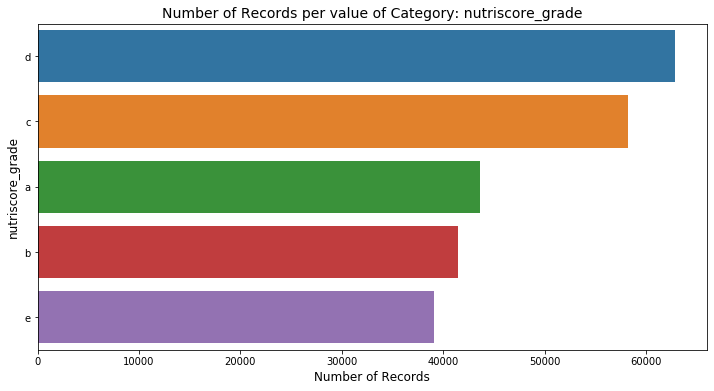

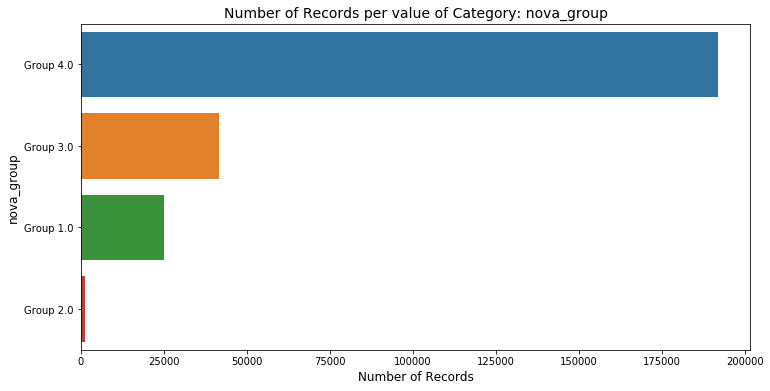

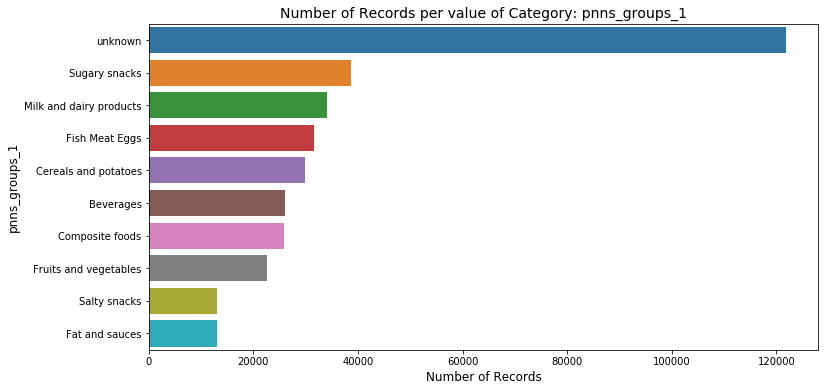

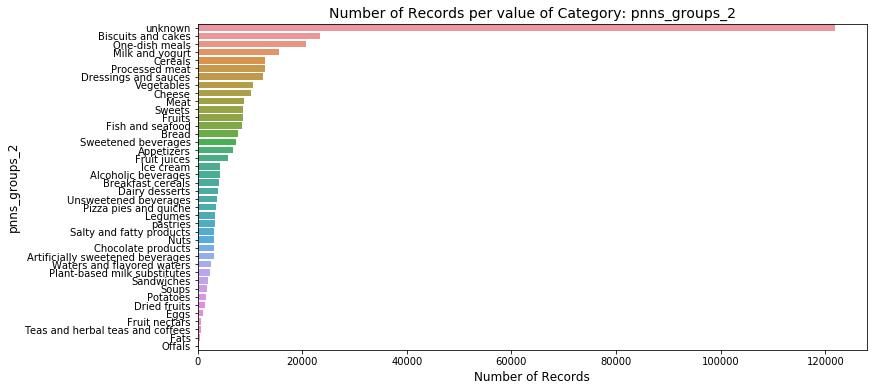

In [12]:
#Generate bar charts for qualitative variables
for i in key_qual_vars:
    fig, ax = plt.subplots(figsize = (12,6))
    plt.title(f'Number of Records per value of Category: {i}', fontsize = 14)
    sns.countplot(y = i, data = data, order = data[i].value_counts().index)
    plt.xlabel('Number of Records', fontsize = 12)
    plt.ylabel(i, fontsize = 12)
    plt.show()

<b>Conclusion:</b> We do not have a homogenic distribution of products. For example, in the Nutriscore grade, we have many more C and D products than healthy products (A and B).<br> 

For the Nova Score, we have the same situation where we have many more 3 and 4 scores (negative) than scores of 1. It is also worth noting that we have no scores of 2. <br>

Given the large sample of readings that we are working with (>200,000 for nutriscore grade and >100,000 for Nova), we can safely assume that this just means that there are more products of poor quality out there. <br>

We also notice that a lot of foods are not categorised, both in PNNS Groups 1 and 2 (category Unknown).

## Multivaried Analyses

As we expect to see a correlation between the Nutriscore Grade/NOVA Score and the amount of certain ingredients present in the food, we expect the distribution to shift along with the different groups. Let's test this with a Violin Plot.

### Quantitative to Qualitative

### Key Variables

#### Nutriscore Grade

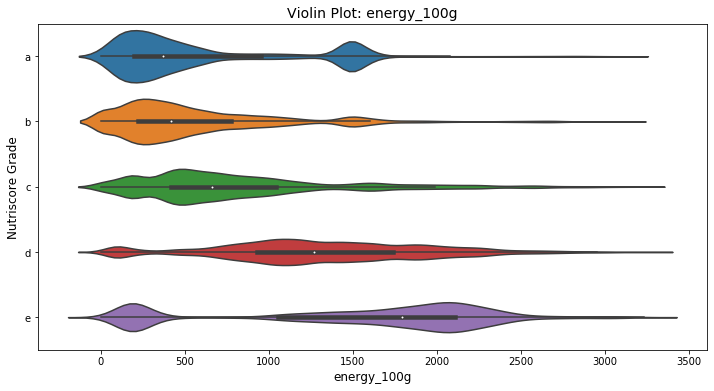

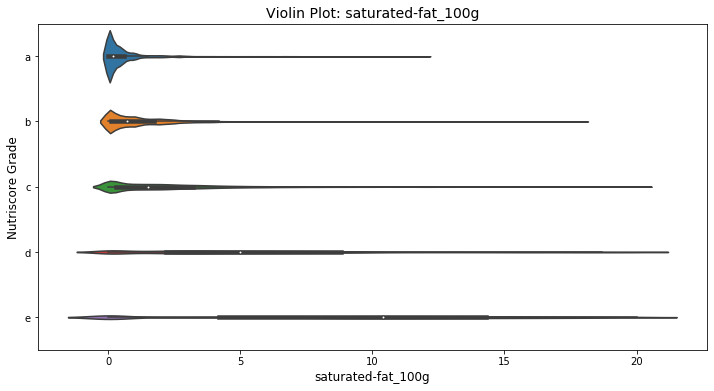

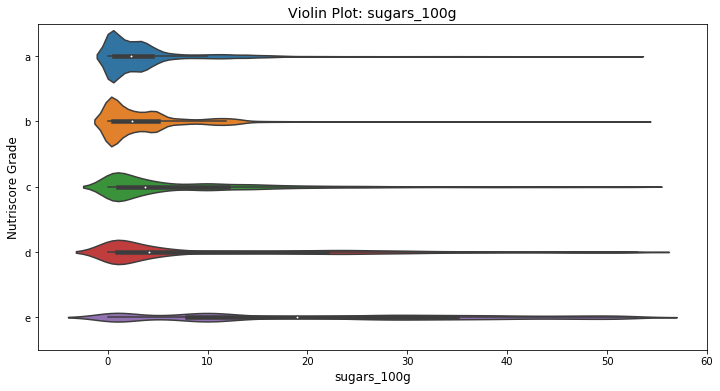

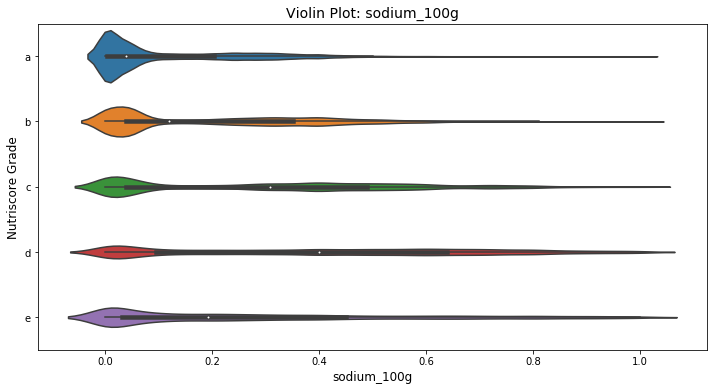

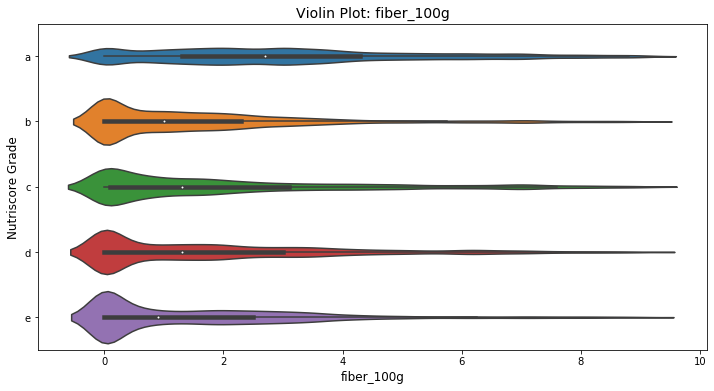

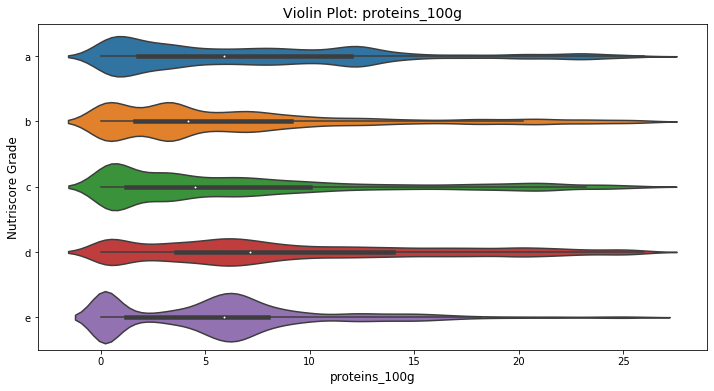

In [13]:
#Generate violin plots for key variables
for i in key_vars:
    fig, ax = plt.subplots(figsize = (12,6))
    sns.violinplot(i,'nutriscore_grade', data = data.sort_values('nutriscore_grade'))
    plt.ylabel('Nutriscore Grade', fontsize = 12)
    plt.xlabel(i, fontsize = 12)
    plt.title(f'Violin Plot: {i}', fontsize = 14)
    plt.show()

<b>Conclusion:</b> As expected, we clearly see that the distribution shifts along the categories. For negative variables, the distribution shifts to the right as the grade gets worse whereas for positive ingredients, the distribution shifts to the left.<br>

#### NOVA Score

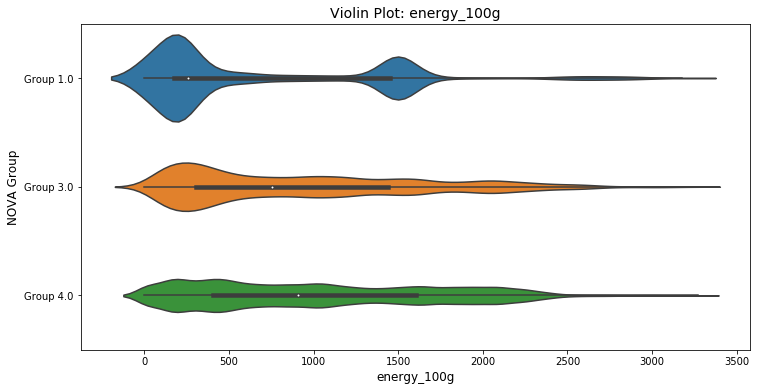

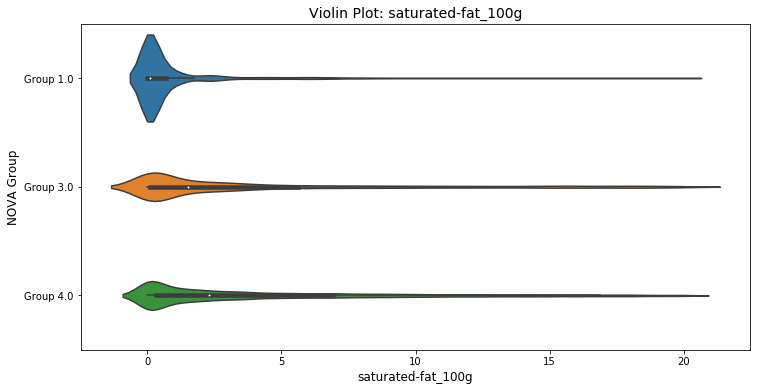

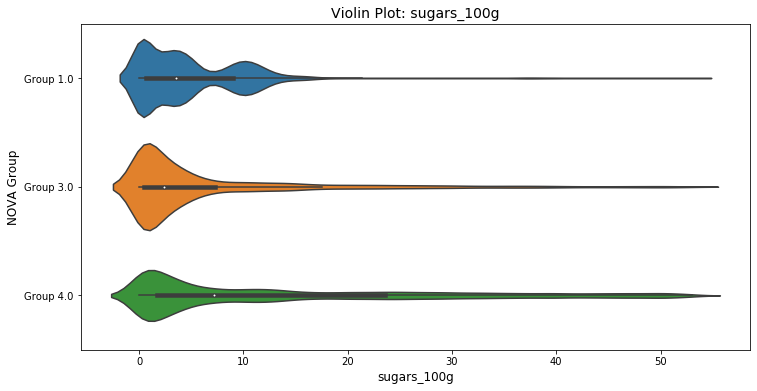

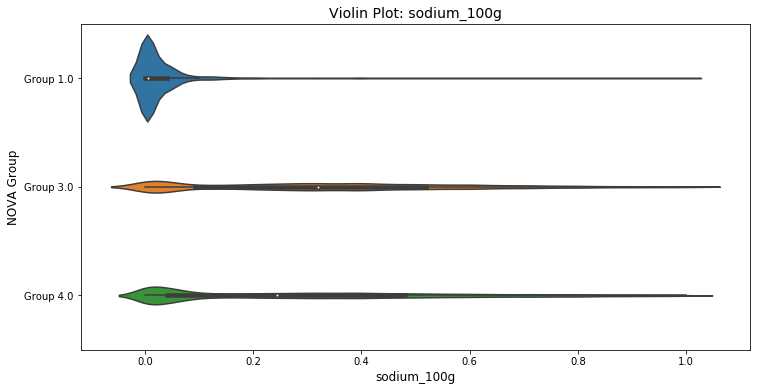

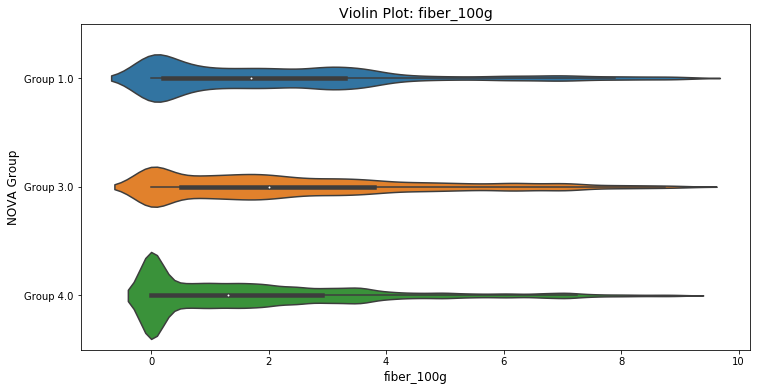

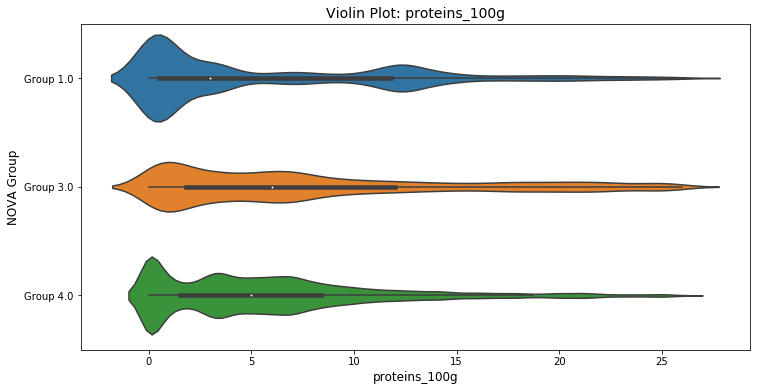

In [14]:
#Violin plot for Nova Groups. We exclude group NAN as these are empty values and we also exclude Group 2 as it only contains 66 records.
for i in key_vars:
    fig, ax = plt.subplots(figsize = (12,6))
    sns.violinplot(i,'nova_group', data = data[(data['nova_group'] != 'Group nan') & (data['nova_group'] != 'Group 2.0')].sort_values('nova_group'))
    plt.ylabel('NOVA Group', fontsize = 12)
    plt.xlabel(i, fontsize = 12)
    plt.title(f'Violin Plot: {i}', fontsize = 14)
    plt.show()

<b>Conclusion:</b> The relationship between Nova Score and these variables is not as obvious as with the Nutrition Score. We will have to further investigate to see whether other variables show a stronger correlation.

### Other Variables

#### Nutriscore Grade

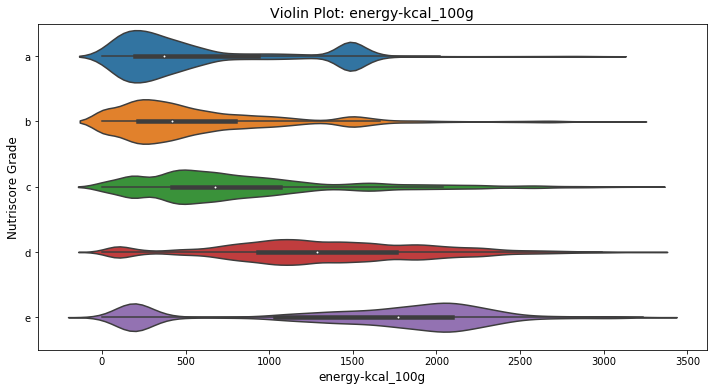

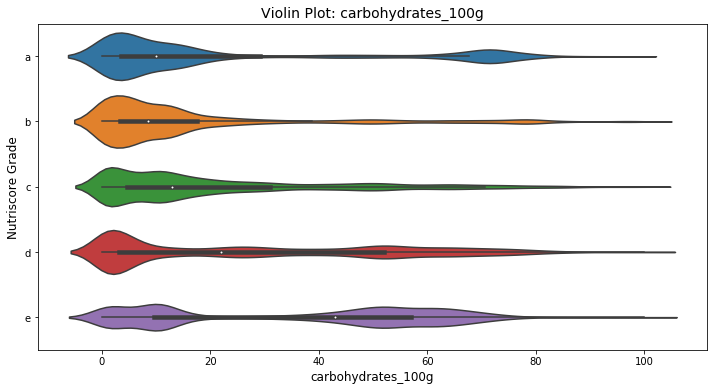

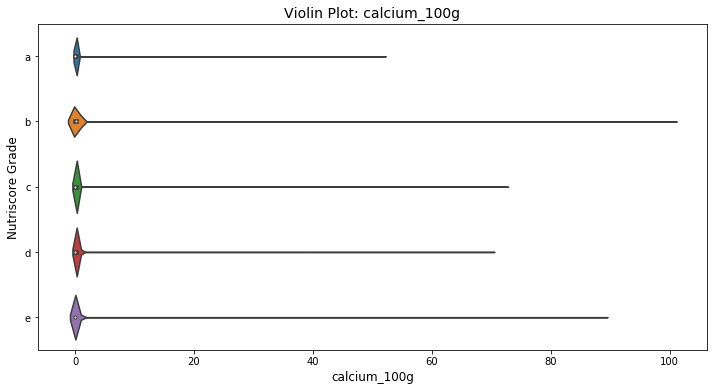

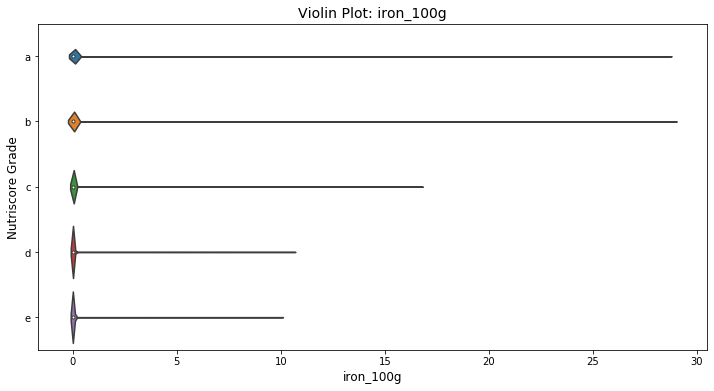

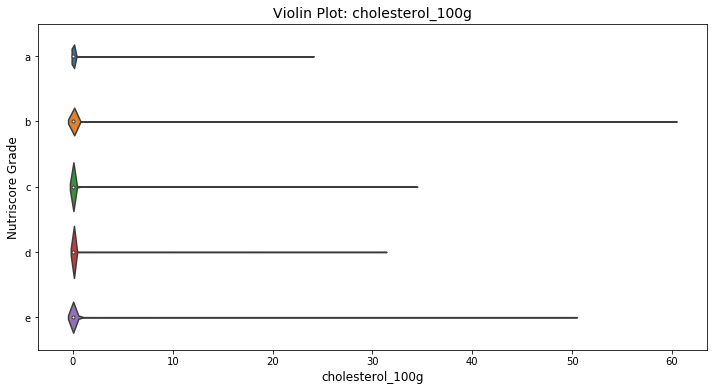

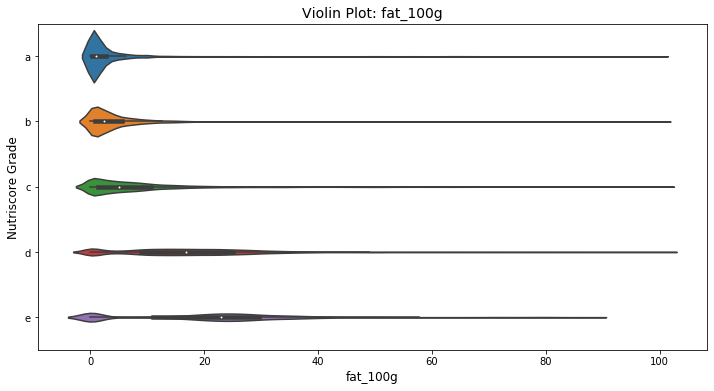

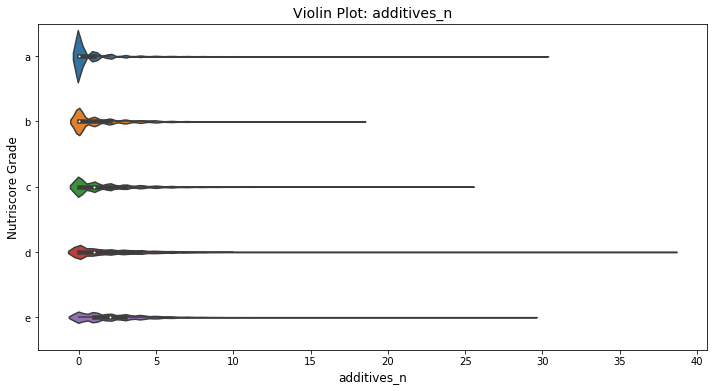

In [15]:
#Generate violin plot for other variables
for i in other_vars:
    fig, ax = plt.subplots(figsize = (12,6))
    sns.violinplot(i,'nutriscore_grade', data = data.sort_values('nutriscore_grade'))
    plt.ylabel('Nutriscore Grade', fontsize = 12)
    plt.xlabel(i, fontsize = 12)
    plt.title(f'Violin Plot: {i}', fontsize = 14)
    plt.show()

<b>Conclusion:</b> At first glance, it looks like certain variables exhibit a correlation. For example Energy_100g, this is not surprising as energy in Calories is one of the key variables. Another variable is fat_100g, again, this is not surprising as we expect this to be correlated with saturated fats, which is one of the key variables.<br>

Other readings are a bit more difficult to interpret due to their long tails but do not seem to display such a clear correlation.

#### NOVA Score

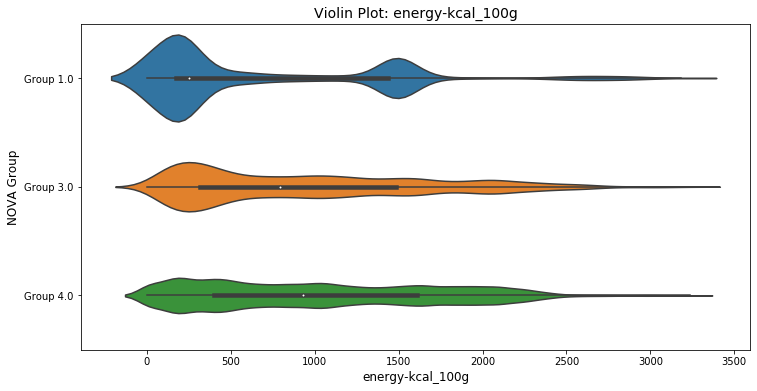

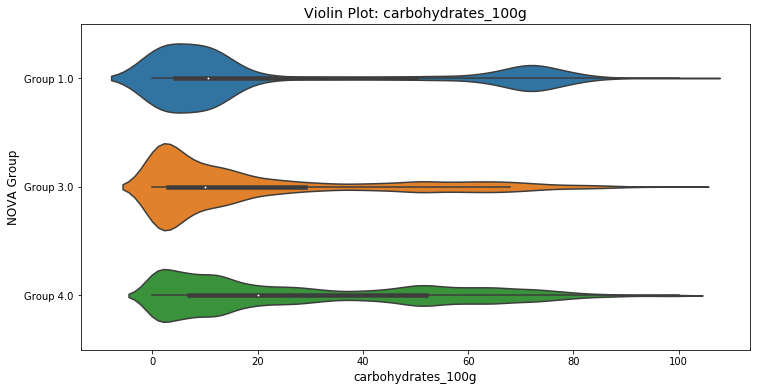

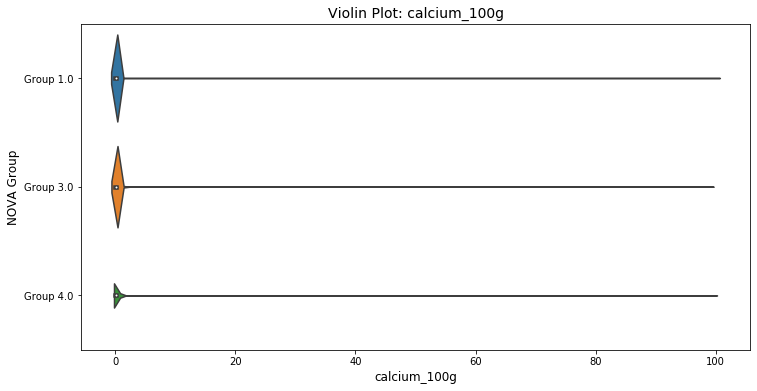

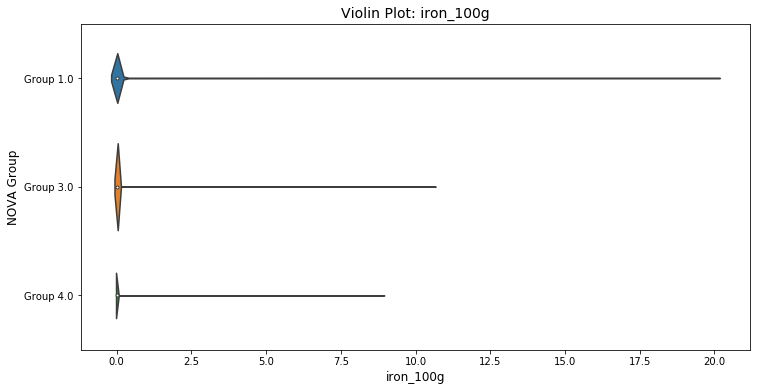

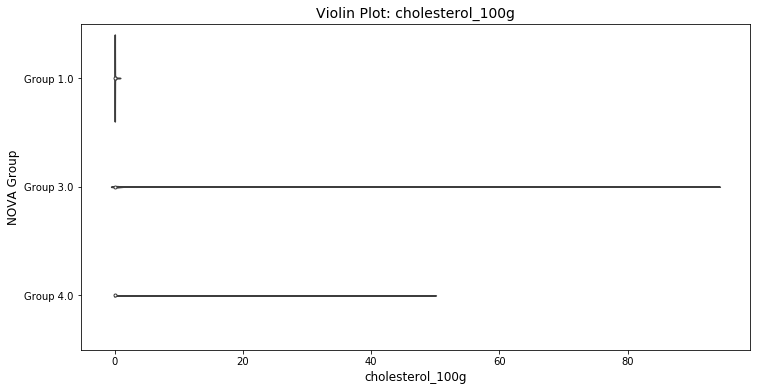

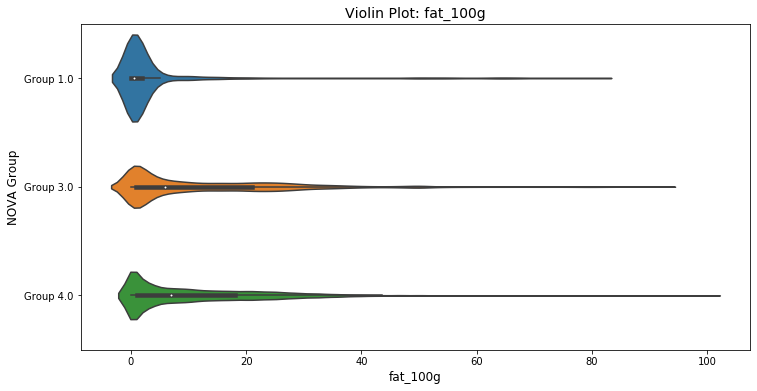

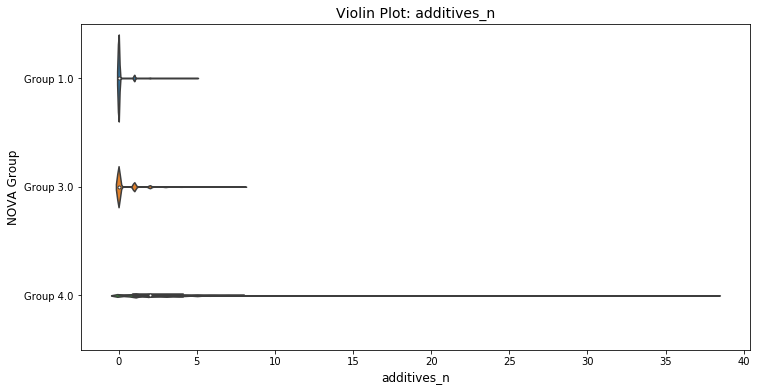

In [16]:
#Violin plot for Nova Groups. We exclude group NAN as these are empty values and we also exclude Group 2 as it only contains 66 records.
for i in other_vars:
    fig, ax = plt.subplots(figsize = (12,6))
    sns.violinplot(i,'nova_group', data = data[(data['nova_group'] != 'Group nan') & (data['nova_group'] != 'Group 2.0')].sort_values('nova_group'))
    plt.ylabel('NOVA Group', fontsize = 12)
    plt.xlabel(i, fontsize = 12)
    plt.title(f'Violin Plot: {i}', fontsize = 14)
    plt.show()

## Calculating Correlation

In [17]:
#When testing for NOVA Score, we need to remove all Group 2 entries (not enough records) and all Null Values. 
#To simplify this going forward, we can create a subset of data with all these values removed.
nova_subset = data[(~data['nova_group'].isnull()) & (data['nova_group'] != 'Group 2.0')]

#We also want to have an easy subset where all null Nutriscore values are dropped
nutri_subset = data[~data['nutriscore_grade'].isnull()]

In [18]:
#Code from OC course located here: 
#https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4774896-analysez-une-variable-quantitative-et-une-qualitative-par-anova

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    result = round(SCE/SCT,2)
    print(f'R-Squared for Variable {i}: {result}')

In [19]:
#Calculating R-Squared for all Key Variables along with Nutriscore Grade
for i in key_vars:
    x = nutri_subset[~nutri_subset[i].isnull()]['nutriscore_grade'] #Qualitative
    y = nutri_subset[~nutri_subset[i].isnull()][i] #Quantitative
    eta_squared(x,y)

R-Squared for Variable energy_100g: 0.26
R-Squared for Variable saturated-fat_100g: 0.39
R-Squared for Variable sugars_100g: 0.21
R-Squared for Variable sodium_100g: 0.14
R-Squared for Variable fiber_100g: 0.06
R-Squared for Variable proteins_100g: 0.03


<b>Conclusion:</b> There seems to be somewhat of a correlation between the Nutriscore Grade and the amount of Saturated Fat. The other variables don't show a very strong correlation.

In [20]:
#Calculating R-Squared for all Key Variables along with NOVA Score
for i in key_vars:
    x = nova_subset[~nova_subset[i].isnull()]['nova_group'] #Qualitative
    y = nova_subset[~nova_subset[i].isnull()][i] #Quantitative
    eta_squared(x,y)

R-Squared for Variable energy_100g: 0.02
R-Squared for Variable saturated-fat_100g: 0.03
R-Squared for Variable sugars_100g: 0.05
R-Squared for Variable sodium_100g: 0.07
R-Squared for Variable fiber_100g: 0.01
R-Squared for Variable proteins_100g: 0.01


<b>Conclusion:</b> There does not seem to be much of a correlation between any of the key variables and the NOVA Score.

In [21]:
#Calculating R-Squared for all Other Variables along with Nutriscore Grade
for i in other_vars:
    x = nutri_subset[~nutri_subset[i].isnull()]['nutriscore_grade'] #Qualitative
    y = nutri_subset[~nutri_subset[i].isnull()][i] #Quantitative
    eta_squared(x,y)

R-Squared for Variable energy-kcal_100g: 0.25
R-Squared for Variable carbohydrates_100g: 0.06
R-Squared for Variable calcium_100g: 0.0
R-Squared for Variable iron_100g: 0.0
R-Squared for Variable cholesterol_100g: 0.0
R-Squared for Variable fat_100g: 0.27
R-Squared for Variable additives_n: 0.07


<b>Conclusion:</b> As we noted from the graphs, only Energy and Fat seem to have any sort of relation to the Nutriscore Grade

In [22]:
#Calculating R-Squared for all Other Variables along with NOVA Score
for i in other_vars:
    x = nova_subset[~nova_subset[i].isnull()]['nova_group'] #Qualitative
    y = nova_subset[~nova_subset[i].isnull()][i] #Quantitative
    eta_squared(x,y)

R-Squared for Variable energy-kcal_100g: 0.02
R-Squared for Variable carbohydrates_100g: 0.02
R-Squared for Variable calcium_100g: 0.0
R-Squared for Variable iron_100g: 0.0
R-Squared for Variable cholesterol_100g: 0.0
R-Squared for Variable fat_100g: 0.02
R-Squared for Variable additives_n: 0.19


<b>Conclusion:</b> Additives seems to be somewhat correlated with the NOVA Group. None of the other variables seem to have any correlation.

In [23]:
#Let's see whether there is a correlation between the Nutriscore (quantitative) and the NOVA score (Qualitative).
x = nova_subset[~nova_subset['nutrition-score-fr_100g'].isnull()]['nova_group'] #Qualitative
y = nova_subset[~nova_subset['nutrition-score-fr_100g'].isnull()]['nutrition-score-fr_100g'] #Quantitative
eta_squared(x,y)

R-Squared for Variable additives_n: 0.13


<b>Conclusion:</b> There seems to be little correlation between the NOVA Group and the Nutrition Score

### Quantitative to Quantitative

The Nutriscore Grade is based on a score. We can use this to perform more correlation analyses to see whether we can find a greater degree of correlation with our selected variables.

#### Key Variables

Let's run a correlation analysis for all the key Variables against the Nutriscore to see whether we find a strong correlation.

In [24]:
for i in key_vars:
    tmp_df = data[[i,'nutrition-score-fr_100g']].dropna()
    pearson = round(st.pearsonr(tmp_df[i], tmp_df['nutrition-score-fr_100g'])[0],2)
    print(f'Correlation between Nutriscore Grade and {i}: {pearson}')

Correlation between Nutriscore Grade and energy_100g: 0.61
Correlation between Nutriscore Grade and saturated-fat_100g: 0.72
Correlation between Nutriscore Grade and sugars_100g: 0.5
Correlation between Nutriscore Grade and sodium_100g: 0.33
Correlation between Nutriscore Grade and fiber_100g: -0.13
Correlation between Nutriscore Grade and proteins_100g: 0.07


<b>Conclusion:</b> There is evidence of quite a high degree of correlation with the negative variables, especially Calories and Saturated Fat.

#### Other Variables

In [25]:
for i in other_vars:
    tmp_df = data[[i,'nutrition-score-fr_100g']].dropna()
    pearson = round(st.pearsonr(tmp_df[i], tmp_df['nutrition-score-fr_100g'])[0],2)
    print(f'Correlation between Nutriscore Grade and {i}: {pearson}')

Correlation between Nutriscore Grade and energy-kcal_100g: 0.61
Correlation between Nutriscore Grade and carbohydrates_100g: 0.29
Correlation between Nutriscore Grade and calcium_100g: 0.01
Correlation between Nutriscore Grade and iron_100g: -0.01
Correlation between Nutriscore Grade and cholesterol_100g: 0.02
Correlation between Nutriscore Grade and fat_100g: 0.61
Correlation between Nutriscore Grade and additives_n: 0.25


<b>Conclusion:</b> Consistent with our previous findings, we see a strong correlation with variables Energy and Fat, but not with the others.

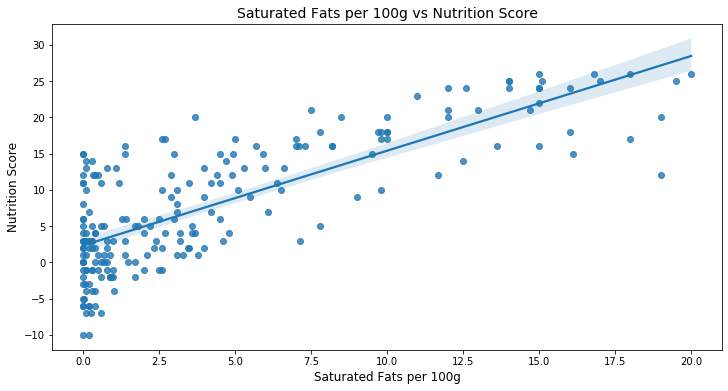

In [26]:
#Saturated Fats have a high correlation with Nutrition Score, let's look at a scatterplot
fig, ax = plt.subplots(figsize = (12,6))
sns.regplot('saturated-fat_100g', 'nutrition-score-fr_100g', data=data.sample(300))
plt.title('Saturated Fats per 100g vs Nutrition Score', fontsize = 14)
plt.xlabel('Saturated Fats per 100g', fontsize = 12)
plt.ylabel('Nutrition Score', fontsize = 12)
plt.show()

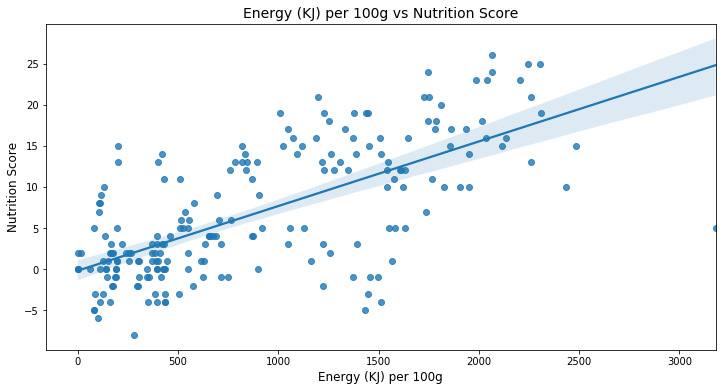

In [27]:
#Same with Energy
fig, ax = plt.subplots(figsize = (12,6))
sns.regplot('energy_100g', 'nutrition-score-fr_100g', data=data.sample(300))
plt.title('Energy (KJ) per 100g vs Nutrition Score', fontsize = 14)
plt.xlabel('Energy (KJ) per 100g', fontsize = 12)
plt.ylabel('Nutrition Score', fontsize = 12)
plt.show()

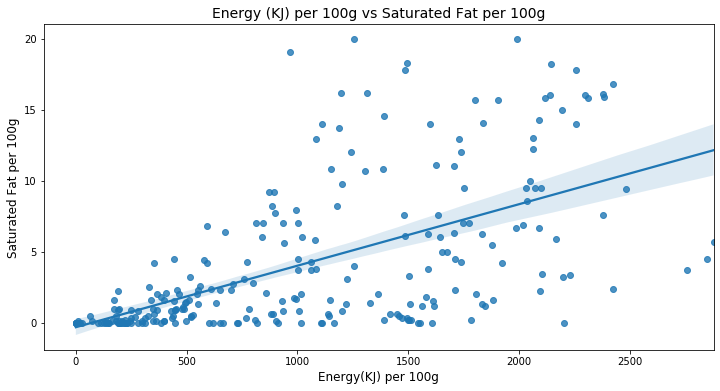

Pearson Coefficient: 0.59


In [28]:
#Are energy and saturated fat correlated with one another?
fig, ax = plt.subplots(figsize = (12,6))
sns.regplot('energy_100g', 'saturated-fat_100g', data=data.sample(300))
plt.title('Energy (KJ) per 100g vs Saturated Fat per 100g', fontsize = 14)
plt.xlabel('Energy(KJ) per 100g', fontsize = 12)
plt.ylabel('Saturated Fat per 100g', fontsize = 12)
plt.show()

tmp_df = data[['saturated-fat_100g','energy_100g']].dropna()
pearson = round(st.pearsonr(tmp_df['saturated-fat_100g'], tmp_df['energy_100g'])[0],2)
plt.show()
print(f'Pearson Coefficient: {pearson}')

<b>Conclusion:</b> There does indeed seem to be a positive correlation between Energy and Saturated Fat

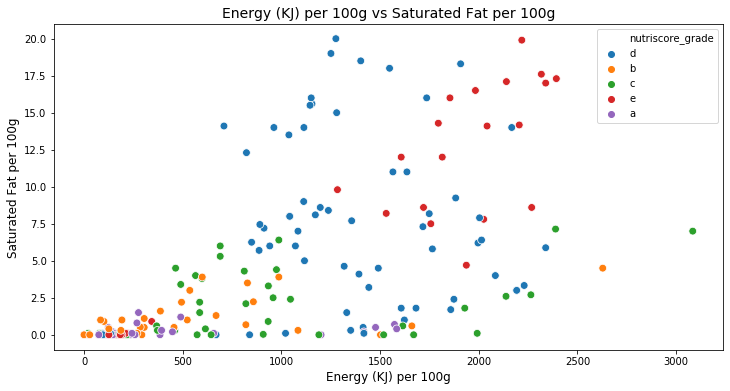

In [29]:
#We can also plot the Nutriscore Grade as a third dimension to the above chart
fig, ax = plt.subplots(figsize = (12,6))
sns.scatterplot('energy_100g', 'saturated-fat_100g', hue='nutriscore_grade', data=data.sample(n=300), s=60)
plt.title('Energy (KJ) per 100g vs Saturated Fat per 100g', fontsize = 14)
plt.xlabel('Energy (KJ) per 100g', fontsize = 12)
plt.ylabel('Saturated Fat per 100g', fontsize = 12)
plt.show()

In [30]:
#Let's investigate whether this correlation is higher in certain product types
for i in data['pnns_groups_1'].unique():
    try:
        if i != 'nan':
            tmp_df = data[data['pnns_groups_1'] == i][['saturated-fat_100g', 'nutrition-score-fr_100g']].dropna()
            x = tmp_df['saturated-fat_100g']
            y = tmp_df['nutrition-score-fr_100g']
            pearson = round(st.pearsonr(x, y)[0],2)
            size = len(tmp_df)
            print(f'Group: {i}, number of records: {size} - Correlation between Nutriscore Grade and Saturated Fats: {pearson}')
    except Exception as e:
        print(str(e))

Group: unknown, number of records: 28057 - Correlation between Nutriscore Grade and Saturated Fats: 0.69
Group: Sugary snacks, number of records: 35226 - Correlation between Nutriscore Grade and Saturated Fats: 0.77
Group: Cereals and potatoes, number of records: 28264 - Correlation between Nutriscore Grade and Saturated Fats: 0.72
Group: Fat and sauces, number of records: 11076 - Correlation between Nutriscore Grade and Saturated Fats: 0.62
Group: Fruits and vegetables, number of records: 20018 - Correlation between Nutriscore Grade and Saturated Fats: 0.28
Group: Salty snacks, number of records: 12372 - Correlation between Nutriscore Grade and Saturated Fats: 0.45
Group: Beverages, number of records: 21711 - Correlation between Nutriscore Grade and Saturated Fats: 0.15
Group: Milk and dairy products, number of records: 32381 - Correlation between Nutriscore Grade and Saturated Fats: 0.87
Group: Fish Meat Eggs, number of records: 29790 - Correlation between Nutriscore Grade and Satura

### Qualitative to Qualitative

In [31]:
#Generate a contingency table
contingency_tbl = nova_subset[['nutriscore_grade', 'nova_group']].pivot_table(index = 'nutriscore_grade', columns = 'nova_group', aggfunc = len, margins = True, margins_name = "Total")

In [32]:
contingency_tbl

nova_group,Group 1.0,Group 3.0,Group 4.0,Total
nutriscore_grade,,,,
a,10259,7445,8415,26119
b,2986,6216,14713,23915
c,2736,8010,24093,34839
d,1122,8343,26690,36155
e,816,3669,18747,23232
Total,17919,33683,92658,144260


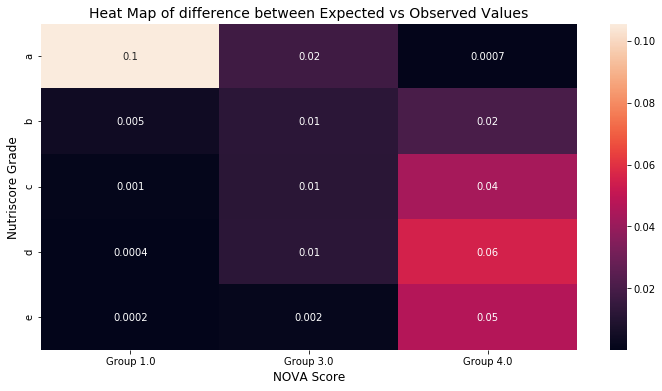

In [33]:
#Generate a Chi-Squared Test and a heat map to show the difference between Expected and Observed values
tx = contingency_tbl.loc[:,["Total"]]
ty = contingency_tbl.loc[["Total"],:]
n = len(data)
expected = tx.dot(ty) / n

c = contingency_tbl.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-expected)**2/expected
xi_n = measure.sum().sum()
table = measure/xi_n
fig, ax = plt.subplots(figsize = (12,6))
plt.title("Heat Map of difference between Expected vs Observed Values", fontsize = 14)
sns.heatmap(table.iloc[:-1,:-1],annot=True, fmt = '.1g')
plt.xlabel('NOVA Score', fontsize = 12)
plt.ylabel('Nutriscore Grade', fontsize = 12)
plt.show()

In [34]:
#Calculate Chi-Squared
cont_no_totals = table.iloc[:-1,:-1]
chi_sq = cont_no_totals.sum().sum()
chi_sq

0.3347444596915312

In [35]:
#Calculate Degrees of Freedom to see whether results are statistically significant

#df = (rows-1)(columns-1)
df = (len(cont_no_totals)-1) * (len(cont_no_totals.columns)-1)
df

8

<b>Conclusion:</b> At a 95% confidence interval for 8 degrees of Freedom, we would need a Chi-Squared of 15.507 or higher to reject the null hypothesis. We can therefore conclude that the Nutriscore Grade does not have an effect on the NOVA Score.

We can also see this visually as in most cases, the observed values are in line with what would be expected were the two variables independent. The only exceptions in the top left corner where we can clearly see that there seems to be a correlation between a food being in Nutriscore Grade A and being in Nova Group 1.

In [36]:
# Test Chi-Squared with product type
contingency_tbl = nova_subset[['pnns_groups_1', 'nova_group']].pivot_table(index = 'pnns_groups_1', columns = 'nova_group', aggfunc = len, margins = True, margins_name = "Total")

In [37]:
contingency_tbl

nova_group,Group 1.0,Group 3.0,Group 4.0,Total
pnns_groups_1,,,,
Beverages,6124,1937,10384,18445
Cereals and potatoes,5021,4663,8555,18239
Composite foods,17,4206,13974,18197
Fat and sauces,179,2388,5777,8344
Fish Meat Eggs,1788,4279,9858,15925
Fruits and vegetables,4678,4918,4710,14306
Milk and dairy products,1777,5768,14232,21777
Salty snacks,623,3442,3902,7967
Sugary snacks,163,2700,22333,25196


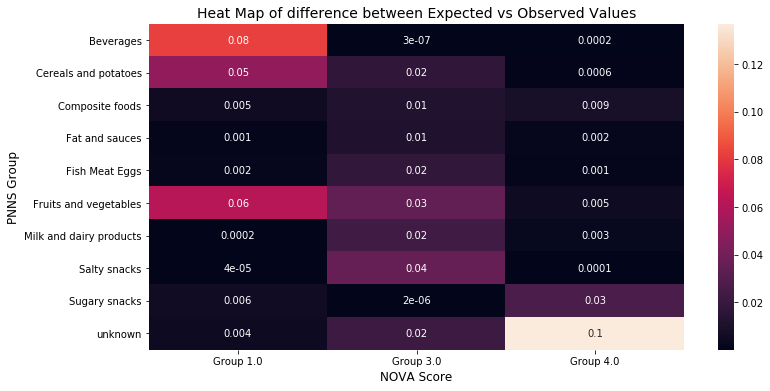

In [38]:
#Generate a Chi-Squared Test and a heat map to show the difference between Expected and Observed values
tx = contingency_tbl.loc[:,["Total"]]
ty = contingency_tbl.loc[["Total"],:]
n = len(data)
expected = tx.dot(ty) / n

c = contingency_tbl.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-expected)**2/expected
xi_n = measure.sum().sum()
table = measure/xi_n
fig, ax = plt.subplots(figsize = (12,6))
plt.title("Heat Map of difference between Expected vs Observed Values", fontsize = 14)
sns.heatmap(table.iloc[:-1,:-1],annot=True, fmt = '.1g')
plt.xlabel('NOVA Score', fontsize = 12)
plt.ylabel('PNNS Group', fontsize = 12)
plt.show()

In [39]:
#Calculate Chi-Squared
cont_no_totals = table.iloc[:-1,:-1]
chi_sq = cont_no_totals.sum().sum()
chi_sq

0.5734718112920991

## Prediction - k-NN

In [40]:
#Set up training and testing data for k-NN Model
from sklearn.model_selection import train_test_split

data_no_na = data[['energy-kcal_100g', 'saturated-fat_100g', 'nutriscore_grade']].dropna()

data_knn = data_no_na[['energy-kcal_100g', 'saturated-fat_100g']]
target_knn = data_no_na['nutriscore_grade']

xtrain, xtest, ytrain, ytest = train_test_split(data_knn, target_knn, train_size=0.8)

In [41]:
#Run algorithm with 3 neighbors
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [42]:
#Check error percentage
error = round((1 - knn.score(xtest, ytest))*100,2)
print(f'Error: {error}%')

Error: 43.79%


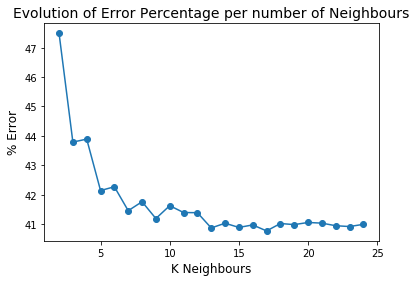

In [43]:
#Run model for different numbers of neighbours to see how this affects the error percentage
errors = []
for k in range(2,25):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,25), errors, 'o-')
plt.title('Evolution of Error Percentage per number of Neighbours', fontsize = 14)
plt.xlabel('K Neighbours', fontsize = 12)
plt.ylabel('% Error', fontsize = 12)
plt.show()

<b>Conclusion:</b> Using just these two variables is not enough to accurately predict the Nutriscore Grade at a reliable, however, it can already help to give an indication of whether the food is healthy or not.

# Conclusions

-The application should be able to estimate the Nutrition Score based on high correlation variables such as Energy (KJ) / 100g and Saturated Fats per 100g. <br>
-Based on the Nutrition Score, the application can convert the score to a Grade. <br>
-If the user fills out additional information (for example a PNNS 1 group or information on other variables), the estimation will be more precise.<br>
-The correlations are not sufficient to accurately estimate the NOVA score which is more complex to calculate.<br>
-The non-key variables do not provide much additional value in terms of correlation except for the Number of Additives, which seems to have a higher correlation with the NOVA Score than other variables. This is however, still not a high correlation.